In [28]:
from functools import partial
from pathlib import Path

from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from itertools import product
from rasterio.windows import Window
import rasterio
import numpy as np
import torchmetrics.functional as metrics
import torch

import dl_toolbox.datasets as datasets
import dl_toolbox.datamodules as datamodules
import dl_toolbox.transforms as tf
import dl_toolbox.utils as utils
import dl_toolbox.modules as modules
import dl_toolbox.networks as networks
import dl_toolbox.losses as losses
import dl_toolbox.callbacks as cb

#if os.uname().nodename == 'WDTIS890Z': 
#    data_root = Path('/mnt/d/pfournie/Documents/data')
#    home = Path('/home/pfournie')
#    save_root = data_root / 'outputs'
#elif os.uname().nodename == 'qdtis056z': 
#    data_root = Path('/data')
#    home = Path('/d/pfournie')
#    save_root = data_root / 'outputs'
#elif os.uname().nodename.endswith('sis.cnes.fr'):
#    home = Path('/home/eh/fournip')
#    save_root = Path('/work/OT/ai4usr/fournip') / 'outputs'
#    if test:
#        data_root = Path('/work/OT/ai4geo/DATA/DATASETS')
#    else:
#        #!bash '/home/eh/fournip/dl_toolbox/copy_data_to_node.sh'
#        data_root = Path(os.environ['TMPDIR'])

In [34]:
base = Path('/scratchm/pfournie/data/DIGITANIE_v4')
imgp = base/'SAN-FRANCISCO/SAN-FRANCISCO_20140113_16bits_COG_9.tif'
with rasterio.open(imgp, "r") as file:
    img = file.read(out_dtype=np.float32, indexes=[1,2,3])
    w, h = file.width, file.height
    
mskp = base/'SAN-FRANCISCO/COS43/SAN-FRANCISCO_9.tif'
with rasterio.open(mskp, "r") as file:
    msk = file.read(out_dtype=np.uint8)
    
merge = 'building'
classes = datasets.Digitanie.classes[merge].value

tiles = list(utils.get_tiles(w,h, 512, step_w=256))
ds = datasets.Digitanie(
    [imgp]*len(tiles),
    [mskp]*len(tiles),
    tiles,
    [1,2,3],
    merge,
    tf.To_0_1_fromNpy(
        city='SAN-FRANCISCO',
        npy=base/'normalisation_stats.npy',
        bands=[1,2,3]
    ),
)

loader = DataLoader(
    dataset=ds,
    collate_fn=utils.CustomCollate(),
    batch_size=8,
    num_workers=0,
    pin_memory=True,
    shuffle=False,
    drop_last=False
)

In [42]:
module = modules.Supervised(
    network=partial(networks.SmpUnet, encoder_name='efficientnet-b0'),
    optimizer=None,
    scheduler=None,
    loss=losses.BCE(predict_zero=True,pixel_weights=None,factor=0),
    class_weights=[0]*len(classes),
    in_channels=3,
    num_classes=len(classes),
    batch_tf=tf.NoOp(),
    metric_ignore_index=0,
    norm=tf.ImagenetNormalize(),
    one_hot=False,
    tta=None
)

In [36]:
merge_preds = cb.MergePreds((w,h))
trainer = Trainer(
    accelerator="cpu",
    devices=1,
    limit_predict_batches=1.,
    callbacks=[merge_preds],
    logger=False
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..


In [50]:
ckpt = '/scratchm/pfournie/outputs/pixel_weights_fulldigi/2023-10-31_171959/0/checkpoints/last.ckpt'
trainer.predict(model=module, dataloaders=loader, ckpt_path=ckpt)
probas = module.loss.prob(merge_preds.merged.unsqueeze(dim=0))
confs, preds = module.probas2confpreds(probas)

Restoring states from the checkpoint path at /scratchm/pfournie/outputs/pixel_weights_fulldigi/2023-10-31_171959/0/checkpoints/last.ckpt
Loaded model weights from the checkpoint at /scratchm/pfournie/outputs/pixel_weights_fulldigi/2023-10-31_171959/0/checkpoints/last.ckpt


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:30<00:00,  4.35s/it]


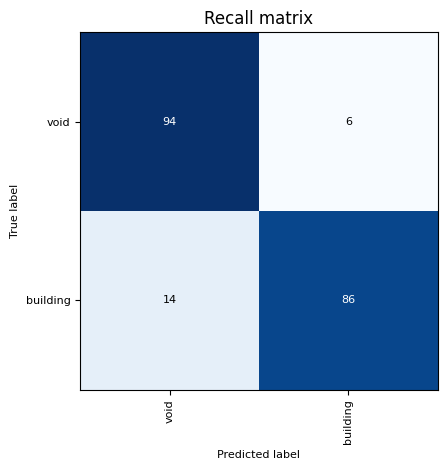

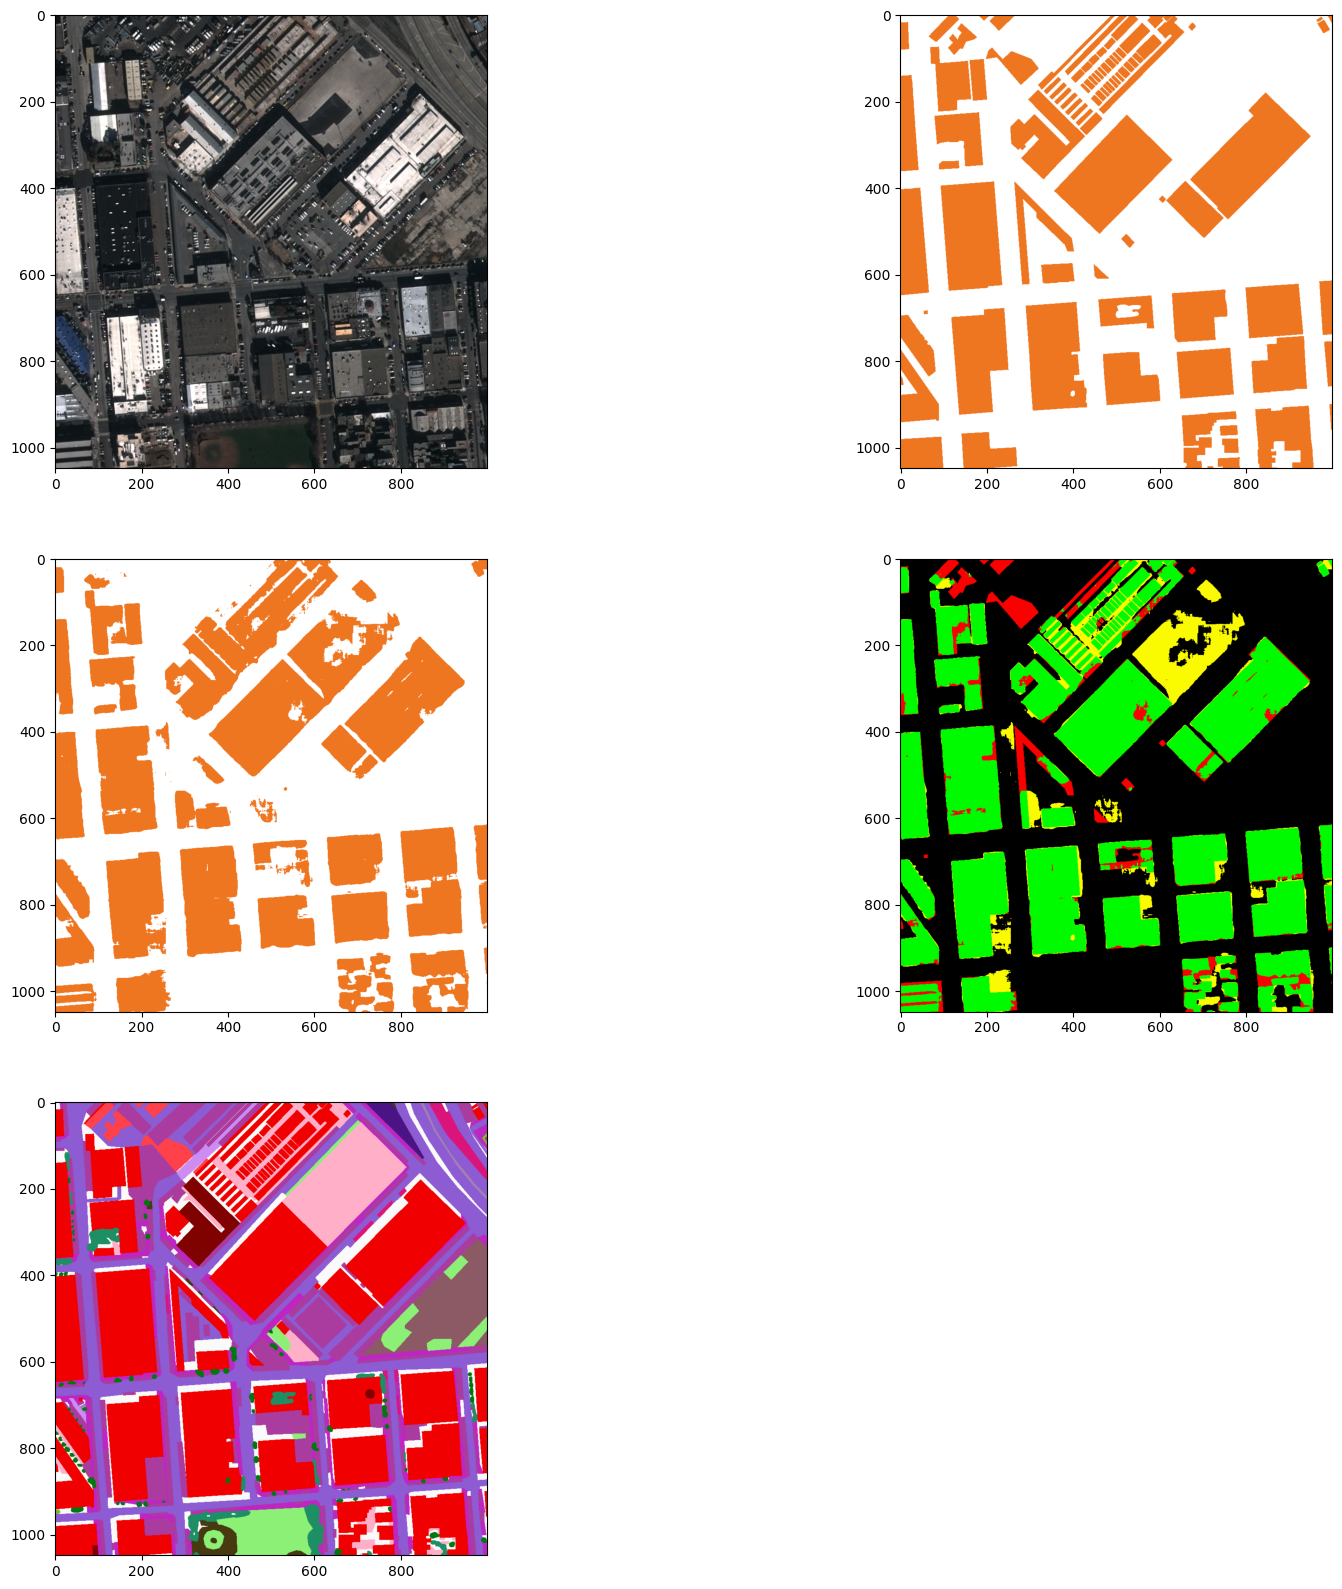

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

img_rgb_np = tf.To_0_1_fromNpy(
        city='SAN-FRANCISCO',
        npy=base/'normalisation_stats.npy',
        bands=[1,2,3]
    )(torch.Tensor(img))[0].numpy()

merges = [list(l.values) for l in classes]
msk_merged_np = utils.merge_labels(msk, merges)

cm = metrics.classification.multiclass_confusion_matrix(
    preds, torch.Tensor(msk_merged_np), num_classes=len(classes)
)
names = [l.name for l in classes]
utils.plot_confusion_matrix(cm, names, "recall", fontsize=8)

preds_np = preds.squeeze().numpy()
msk_np = msk_merged_np.squeeze()
label_bool = msk_np == 1
pred_bool = preds_np == 1
colors = [(i, l.color) for i, l in enumerate(classes)]

overlay = np.zeros(shape=(*preds_np.shape, 3), dtype=np.uint8)
# Correct predictions (Hits) painted with green
overlay[label_bool & pred_bool] = np.array([0, 250, 0], dtype=overlay.dtype)
# Misses painted with red
overlay[label_bool & ~pred_bool] = np.array([250, 0, 0], dtype=overlay.dtype)
# False alarm painted with yellow
overlay[~label_bool & pred_bool] = np.array([250, 250, 0], dtype=overlay.dtype)

zone = np.s_[1000:2048, 0:1000,:3]

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(321)
ax1.imshow(img_rgb_np.transpose(1,2,0)[zone])
ax2 = fig.add_subplot(322)
ax2.imshow(utils.labels_to_rgb(msk_np, colors)[zone])
ax3 = fig.add_subplot(323)
ax3.imshow(utils.labels_to_rgb(preds_np, colors)[zone])
ax4 = fig.add_subplot(324)
ax4.imshow(overlay[zone])
ax2 = fig.add_subplot(325)
full_colors = [(i, l.color) for i, l in enumerate(datasets.Digitanie.classes['all43'].value)] 
ax2.imshow(utils.labels_to_rgb(msk.squeeze(), full_colors)[zone])

In [43]:
ckpt = '/scratchm/pfournie/outputs/pixel_weights_fulldigi/2023-10-31_171959/3/checkpoints/last.ckpt'
trainer.predict(model=module, dataloaders=loader, ckpt_path=ckpt)
probas = module.loss.prob(merge_preds.merged.unsqueeze(dim=0))
confs, preds = module.probas2confpreds(probas)